In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, sum, avg, count, when, datediff, month,expr

# Start Spark session
spark = SparkSession.builder.appName("TravelTourismAnalysis").getOrCreate()


In [0]:
# Load CSV files from your volume
booking_df = spark.read.option("header", True).csv("/Volumes/workspace/default/likhitha/Booking_Details.csv")
customer_df = spark.read.option("header", True).csv("/Volumes/workspace/default/likhitha/Customer_Details.csv")
hotel_df    = spark.read.option("header", True).csv("/Volumes/workspace/default/likhitha/Hotel_Details.csv")




In [0]:
# Example: If check-in is same as booking date + 1 day
from pyspark.sql.functions import expr
booking_df = booking_df.withColumn("CheckIn_Date", expr("date_add(Booking_Date, 1)"))


In [0]:
print("Booking columns:", booking_df.columns)
print("Customer columns:", customer_df.columns)
print("Hotel columns:", hotel_df.columns)


Booking columns: ['booking_id', 'customer_id', 'hotel_id', 'location', 'booking_date', 'stay_duration', 'amount_spent', 'status', 'rating', 'CheckIn_Date']
Customer columns: ['customer_id', 'customer_name', 'city']
Hotel columns: ['hotel_id', 'hotel_name', 'city']


In [0]:
booking_df = booking_df \
    .withColumn("Booking_Date", to_date(col("Booking_Date"), "yyyy-MM-dd")) \
    .withColumn("Stay_Duration", col("Stay_Duration").cast("int")) \
    .withColumn("Amount_Spent", col("Amount_Spent").cast("double")) \
    .withColumn("Rating", col("Rating").cast("double"))


In [0]:
revenue_per_hotel = booking_df.groupBy("Hotel_ID") \
    .agg(sum("Amount_Spent").alias("Total_Revenue"))
revenue_per_hotel.show()


+--------+-------------+
|Hotel_ID|Total_Revenue|
+--------+-------------+
|      50|      6400.35|
|      61|      8600.25|
|      93|       8700.2|
|      79|      8600.25|
|      89|      4700.15|
|      68|      6400.35|
|      87|       9600.5|
|      49|       4700.1|
|      84|       8700.2|
|       2|     12000.75|
|      92|      9800.45|
|      14|       9500.5|
|      60|       9400.5|
|      98|      4600.15|
|      66|       8700.2|
|      48|       8700.2|
|      74|      9800.45|
|      73|       6900.3|
|      40|       4800.1|
|      45|      11500.9|
+--------+-------------+
only showing top 20 rows


In [0]:
avg_stay_location = booking_df.join(hotel_df, "Hotel_ID") \
    .groupBy("City") \
    .agg(avg("Stay_Duration").alias("Avg_Stay_Duration"))
avg_stay_location.show()


+------------------+------------------+
|              City| Avg_Stay_Duration|
+------------------+------------------+
|           Lucknow|3.3333333333333335|
|           Kolkata| 4.333333333333333|
|            Kohima|               6.0|
|          Shillong|               4.0|
|         Amaravati|               3.0|
|            Bhopal| 4.333333333333333|
|             Daman|               2.0|
|Thiruvananthapuram|               2.0|
|       Gandhinagar|               2.0|
|           Chennai|2.6666666666666665|
|            Jaipur|               5.0|
|            Shimla|               6.0|
|          Dehradun|               4.0|
|          Srinagar|               4.0|
|        Port Blair|               5.0|
|            Imphal|               5.0|
|        Chandigarh|               3.8|
|         Kavaratti|               3.0|
|        Puducherry|               5.0|
|             Jammu|               2.0|
+------------------+------------------+
only showing top 20 rows


In [0]:
booking_df.createOrReplaceTempView("booking")
hotel_df.createOrReplaceTempView("hotel")


In [0]:
cancellation_rate = spark.sql("""
    SELECT h.Hotel_Name,
           COUNT(CASE WHEN b.Status = 'cancelled' THEN 1 END) * 100.0 / COUNT(*) AS Cancellation_Rate
    FROM booking b
    JOIN hotel h ON b.Hotel_ID = h.Hotel_ID
    GROUP BY h.Hotel_Name
    ORDER BY Cancellation_Rate DESC
""")
cancellation_rate.show()


+-------------------+------------------+
|         Hotel_Name| Cancellation_Rate|
+-------------------+------------------+
|     Kohima Kingdom|100.00000000000000|
|    Ranchi Radiance|100.00000000000000|
|        Jammu Jewel|100.00000000000000|
|       Daman Dreams|100.00000000000000|
|     Agartala Abode|100.00000000000000|
|      Ranchi Royale|100.00000000000000|
|       Itanagar Inn|100.00000000000000|
|     Ranchi Retreat|100.00000000000000|
|       Bhopal Bliss|100.00000000000000|
|    Bengaluru Bliss|100.00000000000000|
|  Agartala Ambiance|100.00000000000000|
|     Jaipur Jubilee|100.00000000000000|
|Kohima Kaleidoscope|100.00000000000000|
|      Itanagar Icon|100.00000000000000|
|   Bhopal Residency|100.00000000000000|
|      Bhopal Breeze|100.00000000000000|
|  Itanagar Infinity|100.00000000000000|
|    Jaipur Marriott|100.00000000000000|
|          Jammu Joy|100.00000000000000|
|      Agartala Apex|100.00000000000000|
+-------------------+------------------+
only showing top

In [0]:
booking_df = booking_df.withColumn("Month", month("Booking_Date"))
booking_df.createOrReplaceTempView("booking_month")

seasonal_trends = spark.sql("""
    SELECT h.City,
           b.Month,
           SUM(b.Amount_Spent) AS Total_Revenue
    FROM booking_month b
    JOIN hotel h ON b.Hotel_ID = h.Hotel_ID
    GROUP BY h.City, b.Month
    ORDER BY h.City, b.Month
""")
seasonal_trends.show()


+-----------+-----+------------------+
|       City|Month|     Total_Revenue|
+-----------+-----+------------------+
|   Agartala|   12|19401.050000000003|
|     Aizawl|    9|13700.449999999999|
|  Amaravati|    7|           20400.9|
|  Bengaluru|    3|           4500.25|
|  Bengaluru|    8|           17400.4|
|     Bhopal|   11|            6500.1|
|     Bhopal|   12|           19000.9|
|Bhubaneswar|    3|           19600.9|
|Bhubaneswar|    8|           9200.45|
| Chandigarh|    2|            9500.5|
| Chandigarh|    5|           17300.4|
| Chandigarh|    9|           12800.7|
|    Chennai|    4|            8800.0|
|    Chennai|    7|            9600.2|
|      Daman|    4|            9300.2|
|   Dehradun|    2|           17400.4|
|   Dehradun|    9|            8500.2|
|     Dispur|    4|            7800.0|
|     Dispur|    7|           16800.5|
|Gandhinagar|    1|           4800.35|
+-----------+-----+------------------+
only showing top 20 rows


In [0]:
def normalize_columns(pdf):
    pdf.columns = [c.lower() for c in pdf.columns]
    return pdf


/home/spark-c8dc5956-0a77-4fff-bcad-27/.ipykernel/2647/command-6136430202139399-1095882472:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf1, y="hotel_name", x="total_revenue", palette="Blues_d")


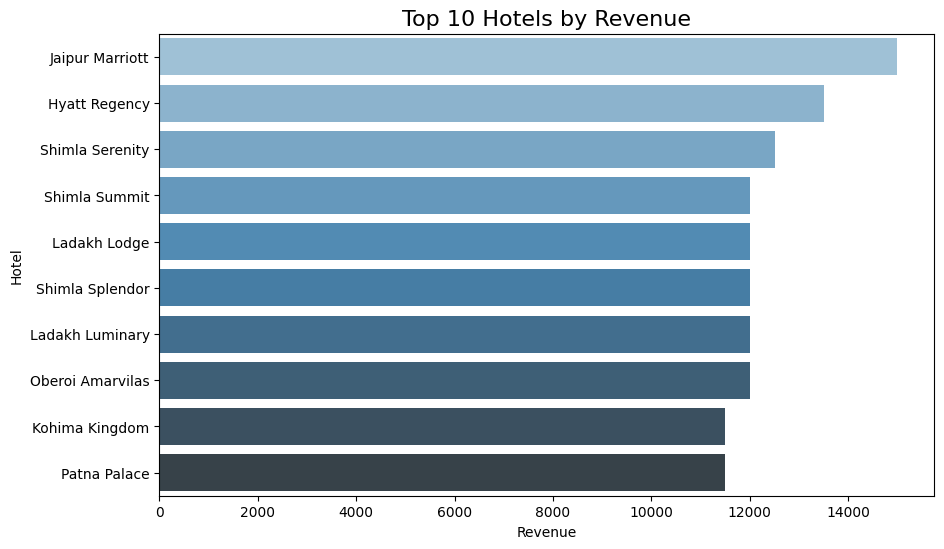

In [0]:
pdf1 = revenue_per_hotel.join(hotel_df, "Hotel_ID").toPandas()
pdf1 = normalize_columns(pdf1)

pdf1 = pdf1.sort_values("total_revenue", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=pdf1, y="hotel_name", x="total_revenue", palette="Blues_d")
plt.title("Top 10 Hotels by Revenue", fontsize=16)
plt.xlabel("Revenue")
plt.ylabel("Hotel")
plt.show()


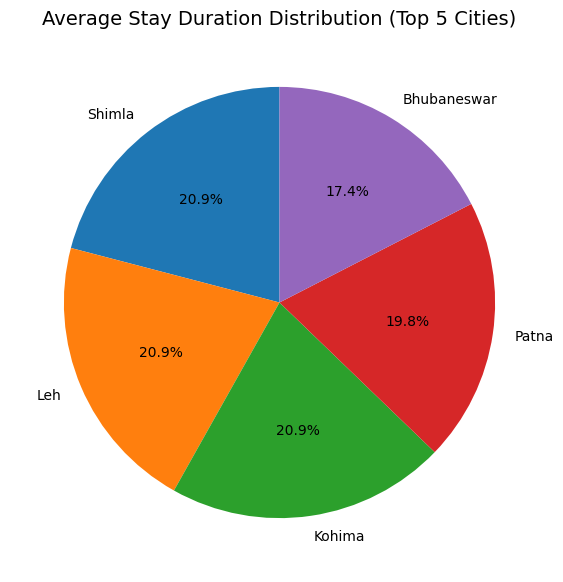

In [0]:
pdf2 = avg_stay_location.toPandas()
pdf2 = normalize_columns(pdf2)

pdf2 = pdf2.sort_values("avg_stay_duration", ascending=False).head(5)

plt.figure(figsize=(7,7))
plt.pie(pdf2["avg_stay_duration"], labels=pdf2["city"], autopct="%1.1f%%", startangle=90)
plt.title("Average Stay Duration Distribution (Top 5 Cities)", fontsize=14)
plt.show()


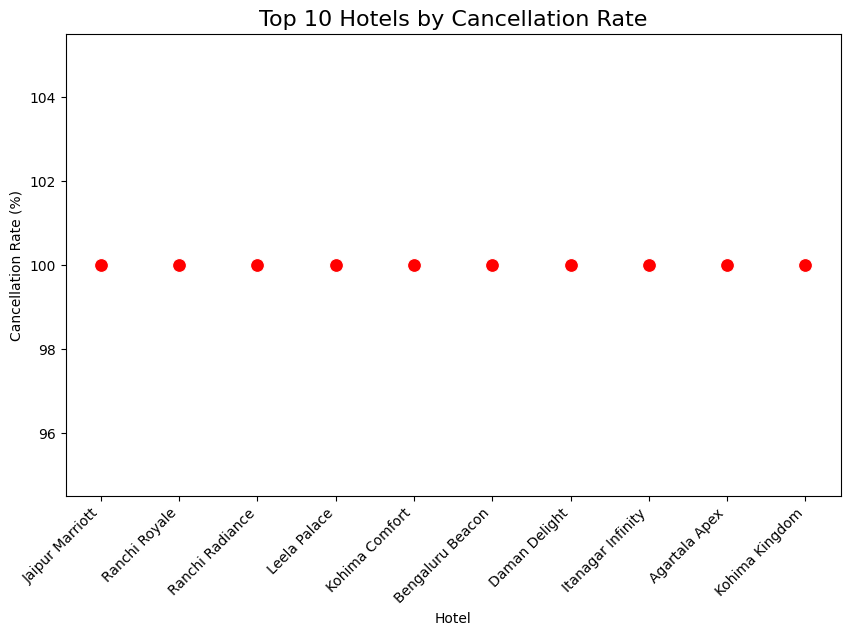

In [0]:
pdf3 = cancellation_rate.toPandas()
pdf3 = normalize_columns(pdf3)

pdf3 = pdf3.sort_values("cancellation_rate", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.scatterplot(data=pdf3, x="hotel_name", y="cancellation_rate", s=100, color="red", marker="o")
plt.title("Top 10 Hotels by Cancellation Rate", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Cancellation Rate (%)")
plt.xlabel("Hotel")
plt.show()


<Figure size 1200x600 with 0 Axes>

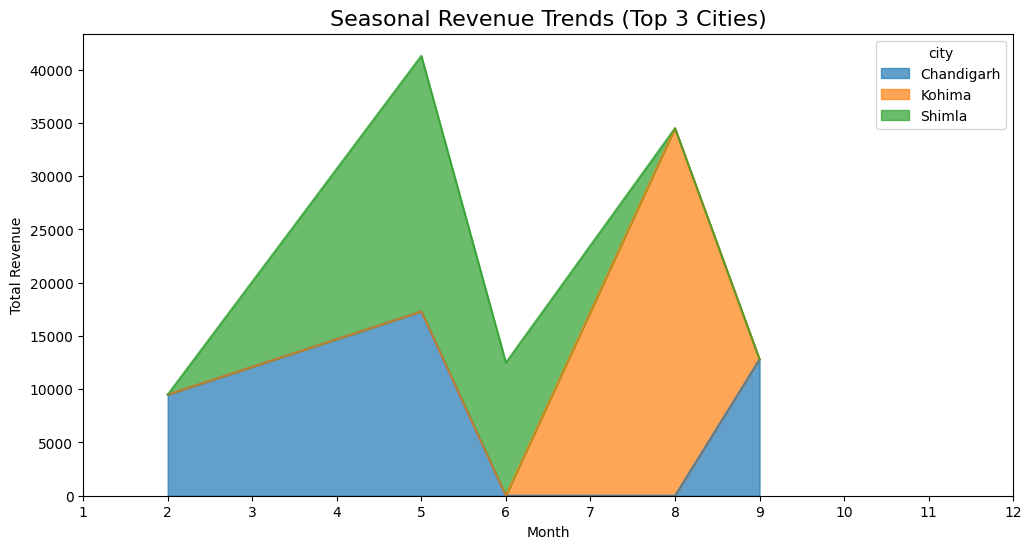

In [0]:
pdf4 = seasonal_trends.toPandas()
pdf4 = normalize_columns(pdf4)

# Keep only top 3 cities for clarity
top_cities = pdf4.groupby("city")["total_revenue"].sum().nlargest(3).index
pdf4 = pdf4[pdf4["city"].isin(top_cities)]

pdf_pivot = pdf4.pivot(index="month", columns="city", values="total_revenue").fillna(0)

plt.figure(figsize=(12,6))
pdf_pivot.plot.area(figsize=(12,6), alpha=0.7)
plt.title("Seasonal Revenue Trends (Top 3 Cities)", fontsize=16)
plt.ylabel("Total Revenue")
plt.xlabel("Month")
plt.xticks(range(1,13))
plt.show()


In [0]:
revenue_per_hotel.show(truncate=False)


+--------+-------------+
|Hotel_ID|Total_Revenue|
+--------+-------------+
|50      |6400.35      |
|61      |8600.25      |
|93      |8700.2       |
|79      |8600.25      |
|89      |4700.15      |
|68      |6400.35      |
|87      |9600.5       |
|49      |4700.1       |
|84      |8700.2       |
|2       |12000.75     |
|92      |9800.45      |
|14      |9500.5       |
|60      |9400.5       |
|98      |4600.15      |
|66      |8700.2       |
|48      |8700.2       |
|74      |9800.45      |
|73      |6900.3       |
|40      |4800.1       |
|45      |11500.9      |
+--------+-------------+
only showing top 20 rows


In [0]:
avg_stay_location.show(truncate=False)


+------------------+------------------+
|City              |Avg_Stay_Duration |
+------------------+------------------+
|Lucknow           |3.3333333333333335|
|Kolkata           |4.333333333333333 |
|Kohima            |6.0               |
|Shillong          |4.0               |
|Amaravati         |3.0               |
|Bhopal            |4.333333333333333 |
|Daman             |2.0               |
|Thiruvananthapuram|2.0               |
|Gandhinagar       |2.0               |
|Chennai           |2.6666666666666665|
|Jaipur            |5.0               |
|Shimla            |6.0               |
|Dehradun          |4.0               |
|Srinagar          |4.0               |
|Port Blair        |5.0               |
|Imphal            |5.0               |
|Chandigarh        |3.8               |
|Kavaratti         |3.0               |
|Puducherry        |5.0               |
|Jammu             |2.0               |
+------------------+------------------+
only showing top 20 rows


In [0]:
cancellation_rate.show(truncate=False)


+-------------------+------------------+
|Hotel_Name         |Cancellation_Rate |
+-------------------+------------------+
|Kohima Kingdom     |100.00000000000000|
|Ranchi Radiance    |100.00000000000000|
|Jammu Jewel        |100.00000000000000|
|Daman Dreams       |100.00000000000000|
|Agartala Abode     |100.00000000000000|
|Ranchi Royale      |100.00000000000000|
|Itanagar Inn       |100.00000000000000|
|Ranchi Retreat     |100.00000000000000|
|Bhopal Bliss       |100.00000000000000|
|Bengaluru Bliss    |100.00000000000000|
|Agartala Ambiance  |100.00000000000000|
|Jaipur Jubilee     |100.00000000000000|
|Kohima Kaleidoscope|100.00000000000000|
|Itanagar Icon      |100.00000000000000|
|Bhopal Residency   |100.00000000000000|
|Bhopal Breeze      |100.00000000000000|
|Itanagar Infinity  |100.00000000000000|
|Jaipur Marriott    |100.00000000000000|
|Jammu Joy          |100.00000000000000|
|Agartala Apex      |100.00000000000000|
+-------------------+------------------+
only showing top

In [0]:
seasonal_trends.show(truncate=False)


+-----------+-----+------------------+
|City       |Month|Total_Revenue     |
+-----------+-----+------------------+
|Agartala   |12   |19401.050000000003|
|Aizawl     |9    |13700.449999999999|
|Amaravati  |7    |20400.9           |
|Bengaluru  |3    |4500.25           |
|Bengaluru  |8    |17400.4           |
|Bhopal     |11   |6500.1            |
|Bhopal     |12   |19000.9           |
|Bhubaneswar|3    |19600.9           |
|Bhubaneswar|8    |9200.45           |
|Chandigarh |2    |9500.5            |
|Chandigarh |5    |17300.4           |
|Chandigarh |9    |12800.7           |
|Chennai    |4    |8800.0            |
|Chennai    |7    |9600.2            |
|Daman      |4    |9300.2            |
|Dehradun   |2    |17400.4           |
|Dehradun   |9    |8500.2            |
|Dispur     |4    |7800.0            |
|Dispur     |7    |16800.5           |
|Gandhinagar|1    |4800.35           |
+-----------+-----+------------------+
only showing top 20 rows
